In [3]:
from IPython.core.debugger import set_trace

%run 'activation.ipynb' 
import numpy as np

class RBM:
    
    def __init__(self, n_v, n_h, W=None, b=None, c=None, k=1):
        assert n_v != 0 and n_h != 0
        self.n_v = n_v
        self.n_h = n_h
        shape = (n_h, n_v)
        
        if W == None: self.W = np.random.uniform(-1, 1, size=shape)
        if b == None: self.b = np.zeros(n_v)
        if c == None: self.c = np.zeros(n_h)

        assert self.W.shape==shape and n_v == len(self.b) and n_h == len(self.c)
        
        self.k = k
        return
        
    def forward(self, V):
        n_sample, n_v = V.shape
        
        hsignal = np.dot(V, self.W.T) + self.c
        assert hsignal.shape == (n_sample, self.n_h)
        Hp = sigmoid(hsignal)
        
        #s = np.random.uniform(0, 1, size=hsignal.shape)
        #Hs = (s < Hp) * 1  # same as:
        Hs = np.random.binomial(1, Hp, size=Hp.shape)
        return Hp, Hs
    
    def backward(self, H):
        n_sample, n_h = H.shape
        
        vsignal = np.dot(H, self.W) + self.b
        assert vsignal.shape == (n_sample, self.n_v)
        #print(vsignal)
        Vp = sigmoid(vsignal)
        
        s = np.random.uniform(0, 1, size=vsignal.shape)
        Vs = (s < Vp) * 1
        return Vp, Vs

    def gibbs(self, V):  #return (probability, samples) of visible units
        Vs = V
        for i in range(self.k):
            Hp, Hs = self.forward(Vs)
            Vp, Vs = self.backward(Hs)
            
        return Hp, Hs, Vp, Vs
    
    def contrastive_divergence(self, V, learning=0.01):
        #set_trace()
        n_sample, n_v = V.shape
        
        Vs = V
        Hp, Hs, Vp_, Vs_ = self.gibbs(Vs)   # underscore _ refers to tilde for negative sample
        Hp_, Hs_ = self.forward(Vs_)

        Vs1 = np.mean(Vs, axis=0) 
        Vs2 = np.mean(Vs_, axis=0) 
        Hp1 = np.mean(Hp, axis=0)
        Hp2 = np.mean(Hp_, axis=0)
        Hs1 = np.mean(Hs, axis=0)
        Hs2 = np.mean(Hs_, axis=0)
        
        # note, there are variances in how to compute the gradients.
        # Hugo suggests:     h(v1)*v1 - h(v2)*v2
        # Bengio suggests:   h1*v1 - h(v2)*v2
        # My derivation:     h1(v1)*v1 - h2*v2 
        
        Eh_b = Vs1; Evh_b = Vs2      # Evh_b refers to the Expectation (over v and h) of -logP(v) gradient wrt b
        
        #Eh_c = Hs1; Evh_c = Hp2  # bengio
        Eh_c = Hp1; Evh_c = Hp2  # hugo
        #Eh_c = Hp1; Evh_c = Hs2  # Mine

        g_b = Evh_b - Eh_b  # gradient of -logP(v) wrt b
        g_c = Evh_c - Eh_c

        Eh_W = np.outer(Eh_c, Eh_b) 
        Evh_W = np.outer(Evh_c, Evh_b)
        g_W = Evh_W - Eh_W
    
        self.W -= g_W * learning
        self.b -= g_b * learning
        self.c -= g_c * learning        
        return
    
    def reconstruct(self, V):
        Hp, Hs = self.forward(V)
        Vp, Vs = self.backward(Hp)
        return Vp, Vs



In [4]:
# testing of the RBM code above

%run "mnist.ipynb"
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Grid

def train_rbm_mnist(train_input, train_size=-1, n_epoch=100, batch_size=10, learning=0.01):
    n_v = 28*28; n_h = 28*5
    rbm = RBM(n_v, n_h)
    n_ep = 0
    n_x = 0 
    X = []
    Y = []
    batch_size = batch_size if batch_size > 0 else 100
    n_epoch = n_epoch if n_epoch > 0 else 1
    for i in range(n_epoch):
        for x, y in train_input.read(train_size):
            n_x += 1
            X.append(x)
            Y.append(y)
            if n_x >= batch_size:
                X = np.array(X).reshape(batch_size, -1) > 30
                X = X * 1 # make bool into number
                Y = np.array(Y)  
                rbm.contrastive_divergence(X, learning)
                n_x = 0
                X = []
                Y = []                

    return rbm

def test_reconstruct_mnist(test_input, rbm, n):
    X=[]
    for x, y in test_input.read(n):
        X.append(x)

    ncols = 10
    nrows = int(n/5)
    fig = plt.figure(figsize=(ncols, nrows), dpi=300)
    grid = Grid(fig, rect=111, nrows_ncols=(nrows,10))
    
    for i, ax in enumerate(grid):
        j = i//2
        if i%2 == 0:
            ax.imshow(X[j].reshape(28,28), cmap=mpl.cm.Greys)
            if i<ncols:
                ax.set_title("Original")
        else:
            Vp, Vs = rbm.reconstruct(X[j].reshape(1, -1)/255)
            ax.imshow(Vp.reshape(28,28), cmap=mpl.cm.Greys)
            if i<ncols:
                ax.set_title("Reconst.")
  
        ax.set_axis_off()
        
    fig.suptitle('Original and reconstructed digits side by side')
    fig.tight_layout()
    fig.subplots_adjust(top=0.80)    
    plt.show()        
    return

def show_features_mnist(rbm):
    maxw = np.amax(rbm.W)
    minw = np.amin(rbm.W)
    ncols = rbm.n_h if rbm.n_h < 14 else 14 
    nrows = int(rbm.n_h/ncols)
    fig = plt.figure(figsize=(ncols, nrows), dpi=100)
    grid = Grid(fig, rect=111, nrows_ncols=(nrows, ncols), axes_pad=0.01)

    for i, ax in enumerate(grid):
        x = rbm.W[i]
        x = (x.reshape(1, -1) - minw)/maxw
        ax.imshow(x.reshape(28,28), cmap=mpl.cm.Greys)
        ax.set_axis_off()

    fig.suptitle('Features learned with RBM from MNIST', size=20)
    fig.tight_layout()
    fig.subplots_adjust(top=0.92)    
    plt.show()
    return


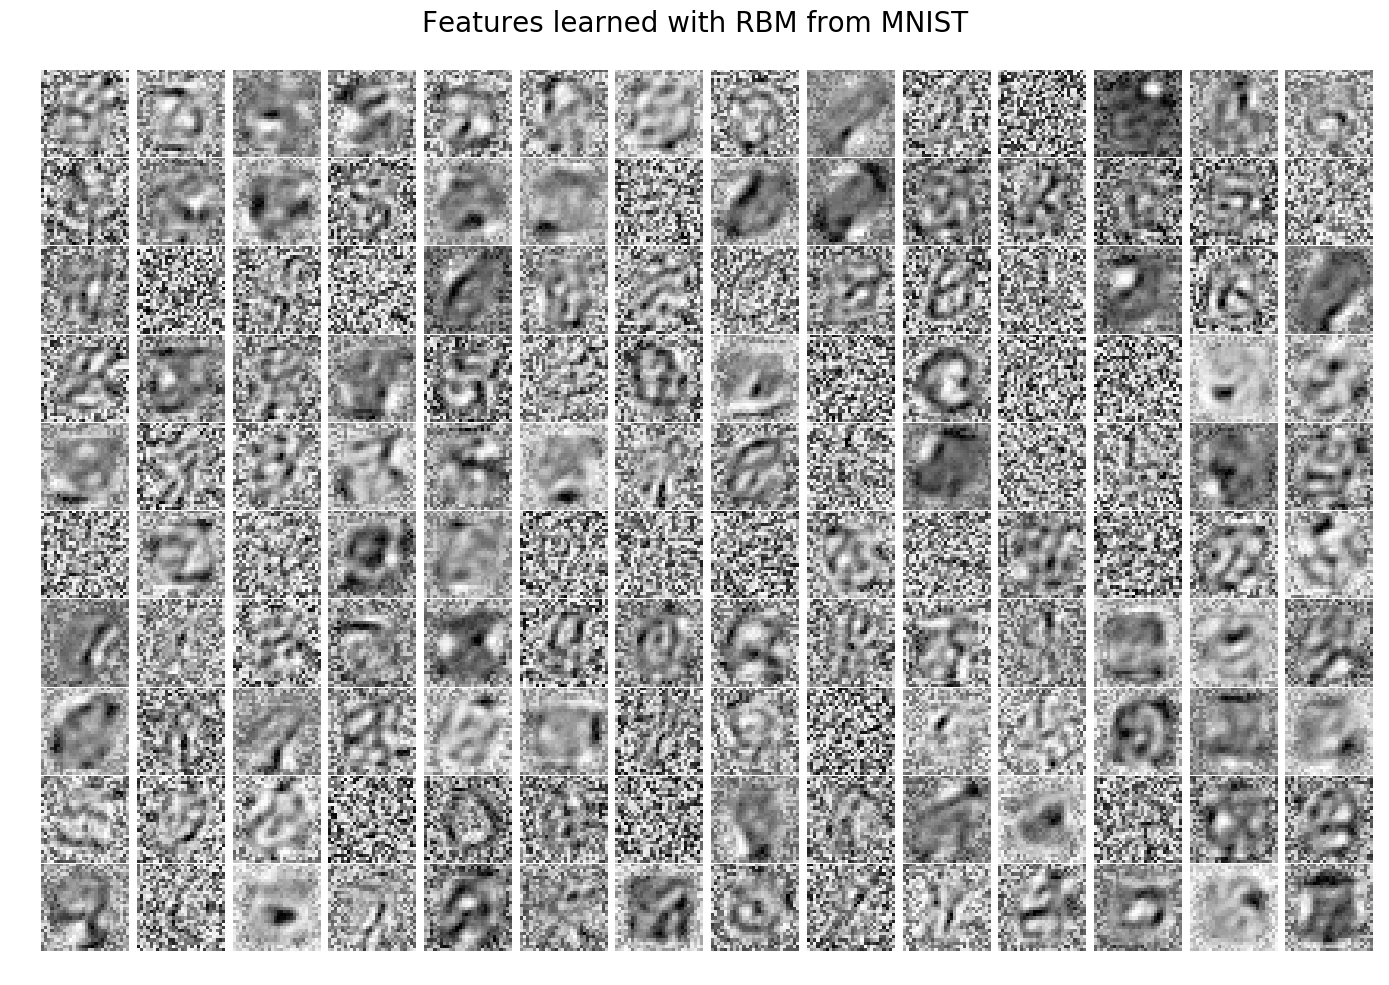

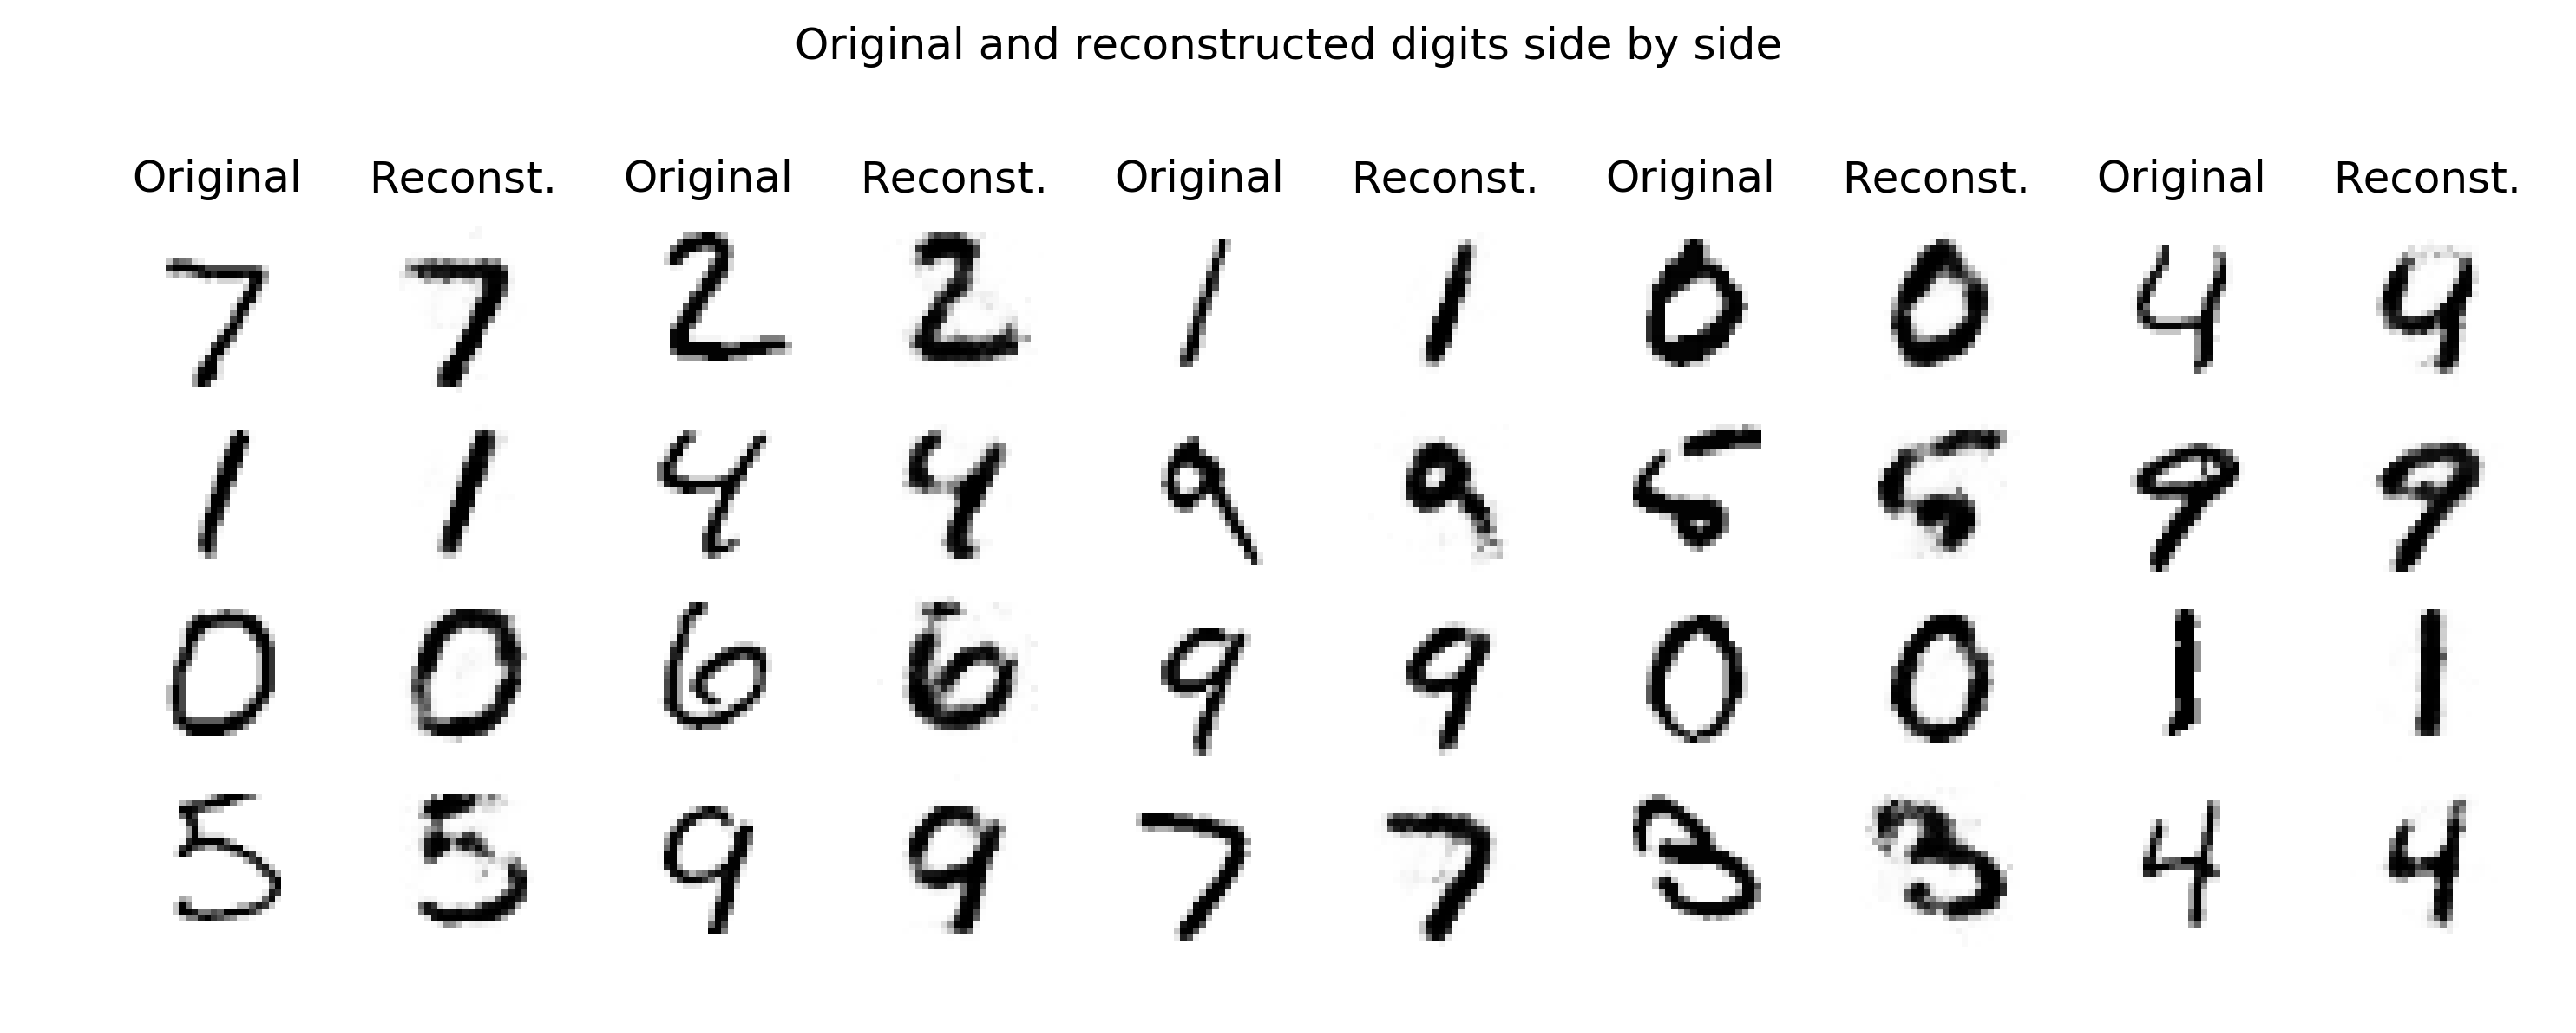

In [5]:
rbm = None
if __name__ == "__main__" and '__file__' not in globals():
    
    np.seterr(all='raise')
    plt.close('all')
    train_input = MnistInput("train", "../convolution-network")
    test_input = MnistInput("test", "../convolution-network")
    rbm = train_rbm_mnist(train_input)
    show_features_mnist(rbm)
    test_reconstruct_mnist(test_input, rbm, 20)